In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sunspots/Sunspots.csv


In [2]:
import csv
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
timestep=[]
temp=[]
step=0
with open('/kaggle/input/sunspots/Sunspots.csv') as csvfile:
    reader=csv.reader(csvfile,delimiter=',')
    next(reader)
    
    for row in reader:
        temp.append(float(row[2]))
        timestep.append(step)
        step+=1
    
    

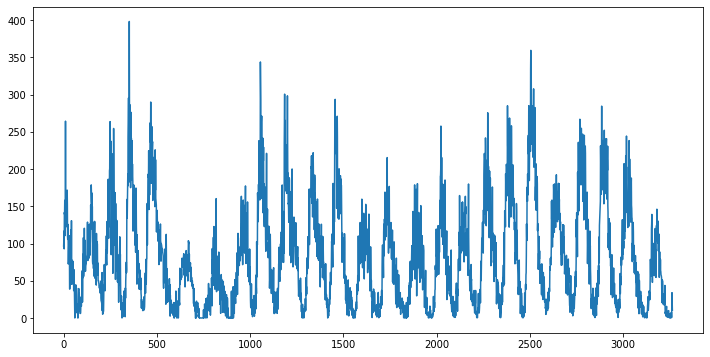

In [7]:
plt.figure(figsize=(12,6))
plt.plot(timestep,temp)

In [33]:
series=np.array(temp)
time=np.array(timestep)

split_time=3000
time_train=time[:split_time]
temp_train=series[:split_time]
time_valid=time[split_time:]
temp_valid=series[split_time:]

In [34]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [35]:
def windowed_set(series,batch_size,window_size,shuffle_buffer_size):
    series=tf.expand_dims(series,axis=-1)
    df=tf.data.Dataset.from_tensor_slices(series)
    df=df.window(window_size+1,shift=1,drop_remainder=True)
    df=df.flat_map(lambda window:window.batch(window_size+1))
    df=df.shuffle(shuffle_buffer_size).map(lambda window:(window[:-1],window[-1]))
    df=df.batch(batch_size).prefetch(1)
    return df

In [36]:
train_series=windowed_set(temp_train,100,60,1000)

In [37]:
train_series

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>

In [38]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(filters=32,kernel_size=5,padding='causal',activation='relu',strides=1,input_shape=[None,1]))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dense(30,activation='relu'))
model.add(tf.keras.layers.Dense(10,activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Lambda(lambda x:x *400))


In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 128)         49664     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_6 (Dense)              (None, 30)                3870      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
_________________________________________________________________
lambda_2 (Lambda)            (None, 1)                

In [22]:
lr_scheduler=tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-8*10**(epoch/20))

In [40]:
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [41]:
history=model.fit(train_series,epochs=500)

Epoch 1/500
30/30 [==============================] - 5s 22ms/step - loss: 74.5237 - mae: 75.0228
Epoch 2/500
30/30 [==============================] - 1s 23ms/step - loss: 27.5448 - mae: 28.0409
Epoch 3/500
30/30 [==============================] - 1s 22ms/step - loss: 23.2657 - mae: 23.7598
Epoch 4/500
30/30 [==============================] - 1s 22ms/step - loss: 22.7247 - mae: 23.2186
Epoch 5/500
30/30 [==============================] - 1s 22ms/step - loss: 21.7411 - mae: 22.2347
Epoch 6/500
30/30 [==============================] - 1s 27ms/step - loss: 21.9176 - mae: 22.4119
Epoch 7/500
30/30 [==============================] - 1s 24ms/step - loss: 21.5495 - mae: 22.0439
Epoch 8/500
30/30 [==============================] - 1s 22ms/step - loss: 20.7541 - mae: 21.2477
Epoch 9/500
30/30 [==============================] - 1s 22ms/step - loss: 20.5828 - mae: 21.0752
Epoch 10/500
30/30 [==============================] - 1s 22ms/step - loss: 20.4057 - mae: 20.8979
Epoch 11/500
30/30 [=========

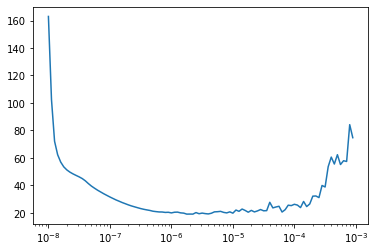

In [27]:
plt.semilogx(history.history['lr'],history.history['loss'])

In [43]:
forecast=[]
for time in range(len(series)-60):
    serie1=series[time:time+60][np.newaxis]
    serie1=tf.expand_dims(serie1,axis=-1)
    forecast.append(model.predict(serie1))


In [49]:
results=np.array(forecast)[:,0,0]

In [54]:
len(results[split_time-60:])


265

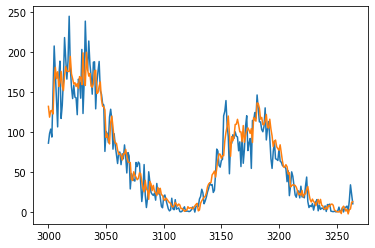

In [58]:
plt.plot(time_valid,temp_valid)
plt.plot(time_valid,results[split_time-60:])

In [60]:
tf.keras.metrics.mean_absolute_error(temp_valid,results[split_time-60:]).numpy()


13.596605